# Hotel Booking Analytics: Cencellation in Hotel Booking
### Created By : Hilfi Biyan Firza

## Business Problem Understanding

**Context**  
Industri perhotelan menghadapi tantangan serius dengan tingginya angka pembatalan pemesanan. Berdasarkan data dari [d-edge](https://www.d-edge.com/hotel-distribution-and-the-pandemic-the-travel-chessboard/), sekitar 20 hingga 40% pemesanan hotel mengalami pembatalan pada kuatral pertama 2016. Angka persentase pembatalan ini kembali meningkat terutama pada masa pandemi COVID-19 mengalami pembatalan sebesar 71% di kanal pemesanan online Expedia dan di kanal pemesanan lain persentase pembatalan pemesanan hotel berkisar pada angka 32% hingga 63%. Pembatalan mendadak menyebabkan kerugian pendapatan dan menurunnya efisiensi penggunaan kamar. Tanpa sistem prediktif, hotel tidak dapat mengantisipasi risiko ini secara proaktif. 

Oleh sebab itu, hotel ingin mengetahui tamu mana yang kemungkianan melakukan pembatalan pemesanan kamar hotel. Hal tersebut sangat berguna bagi meningkatkan tingkat keterisian hotel yang berujung pada pendapatan hotel tersebut.

Target : `is_canceled`

0 : booking TIDAK di cancel

1 : booking di cancel

**Problem Statement :**

Tingkat pembatalan (cancellation) pada pemesanan hotel menyebabkan ketidakpastian dalam operasional dan perencanaan hotel. Hal ini mempengaruhi pendapatan dan efisiensi sumber daya. Oleh karena itu, penting bagi hotel untuk dapat memprediksi apakah suatu reservasi akan dibatalkan atau tidak.

**Stakeholder :**

- Manajer Operasional Hotel: untuk mengantisipasi kapasitas kamar.
- Tim Marketing: untuk menyesuaikan strategi promosi terhadap pelanggan berisiko tinggi.
- Customer Service: untuk meningkatkan follow-up kepada pelanggan berpotensi membatalkan reservasi.

**Objective :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin membangun model machine learning yang dapat memprediksi kemungkinan pembatalan reservasi hotel, sehingga pihak hotel dapat melakukan mitigasi atau strategi yang sesuai.

Dan juga, perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat seorang melakukan pembatalan booking atau tidak, sehingga mereka dapat memiliki strategi yang lebih baik dalam mengatasi potensi pembatalan oleh pelanggan.

**Business Impact**

Dengan model prediksi ini, pihak hotel dapat:
- Mengurangi kehilangan pendapatan akibat pembatalan.
- Mengoptimalkan alokasi kamar dan tenaga kerja.
- Menyesuaikan promosi atau kebijakan pembayaran.

**Analytical Approach :**  

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan tamu yang kemungkinan melakukan pembatalan pemesan dengan tamu yang tidak membatalakan pemesanan.

Kemudian kita akan membangun model klasifikasi menggunakan supervised learning dengan algoritma Logistic Regression, Random Forest, dan XGBoos yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang tamu akan melakukan pembatalan booking atau tidak.

**Evaluation Metric :**

- Fokus pada **Recall** dan **F1 Score**  
- Visualisasi: Confusion Matrix

**Indikator Kinerja**
- Recall class 1 (pembatalan) ≥ 80% → penting untuk deteksi dini.
- Precision class 1 ≥ 60% → menghindari false positive yang berlebihan.
- ROC AUC ≥ 0.8 → model stabil dan generalisasi baik.

## Data Understanding

Dataset source : https://drive.google.com/drive/folders/17KIeOXK7eYGuzgpn_IljlUFcE4v96lSL

Note : 
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary)
- Setiap baris data merepresentasikan informasi terkait data booking di masa lalu

### Attribute Information

| Attribute | Data Type | Description |
| --- | --- | --- |
| country | Object | Country of origin |
| market_segment | Object | Market segment designation |
| previous_cancellations | Int64 | Number of previous bookings that were cancelled by the customer prior to the current booking |
| booking_changes | Int64 | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | object | Indication on if the customer made a deposit to guarantee the booking |
| days_in_waiting_list | Int64 | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Object | Type of booking |
| reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| required_car_parking_space | Int64 | Number of car parking spaces required by the customer |
| total_of_special_request | int64 | Number of special requests made by the customer (e.g. twin bed or high floor) |
| is_canceled | Int64 | Value indicating if the booking was canceled (1) or not (0) |

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

## Uji Statistik
from scipy.stats import chi2_contingency

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from scipy.stats import randint, uniform

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
## Load dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


## Data Cleaning

Ada data yang hilang/kosong dibeberapa fitur/kolom, maka kita akan memperbaiki semua datanya dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

sebelum itu, kita akan membuat salinan dataframe untuk diproses lebih jauh

In [4]:
df_clean = df.copy()

In [5]:
listItem = []
for col in df_clean.columns :
    listItem.append([col, df_clean[col].dtype, df_clean[col].isna().sum(), round((df_clean[col].isna().sum()/len(df_clean[col])) * 100,2),
                    df_clean[col].nunique(), list(df_clean[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[RWA, PAN]"
1,market_segment,object,0,0.00,8,"[Groups, Aviation]"
2,previous_cancellations,int64,0,0.00,15,"[19, 14]"
3,booking_changes,int64,0,0.00,19,"[6, 12]"
4,deposit_type,object,0,0.00,3,"[Non Refund, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[187, 22]"
6,customer_type,object,0,0.00,4,"[Transient-Party, Transient]"
7,reserved_room_type,object,0,0.00,10,"[D, B]"
8,required_car_parking_spaces,int64,0,0.00,5,"[2, 8]"
9,total_of_special_requests,int64,0,0.00,6,"[0, 5]"


Dari data tersebut bisa kita perhatikan bahwa tidak ada data yang duplikat. namun pada kolom Country terdapat 351 data yang null.
berdasarkan pada tipe data juga, tipe data sudah sesuai dengan jenis datanya.

#### Bar Plot

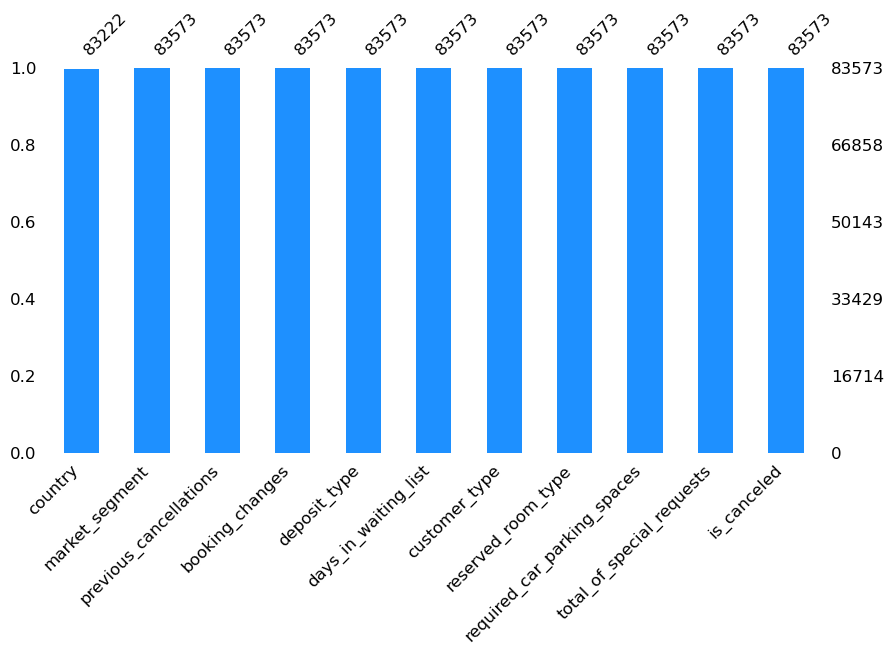

In [6]:
missingno.bar(df_clean,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

Terlihat dari Bar Plot tersebut, bahwa hanya kolom country yang memiliki missing values/data yang hilang. (informasi ini juga sebenarnya dapat dilihat pada table atas)

#### Matrix Plot

<Axes: >

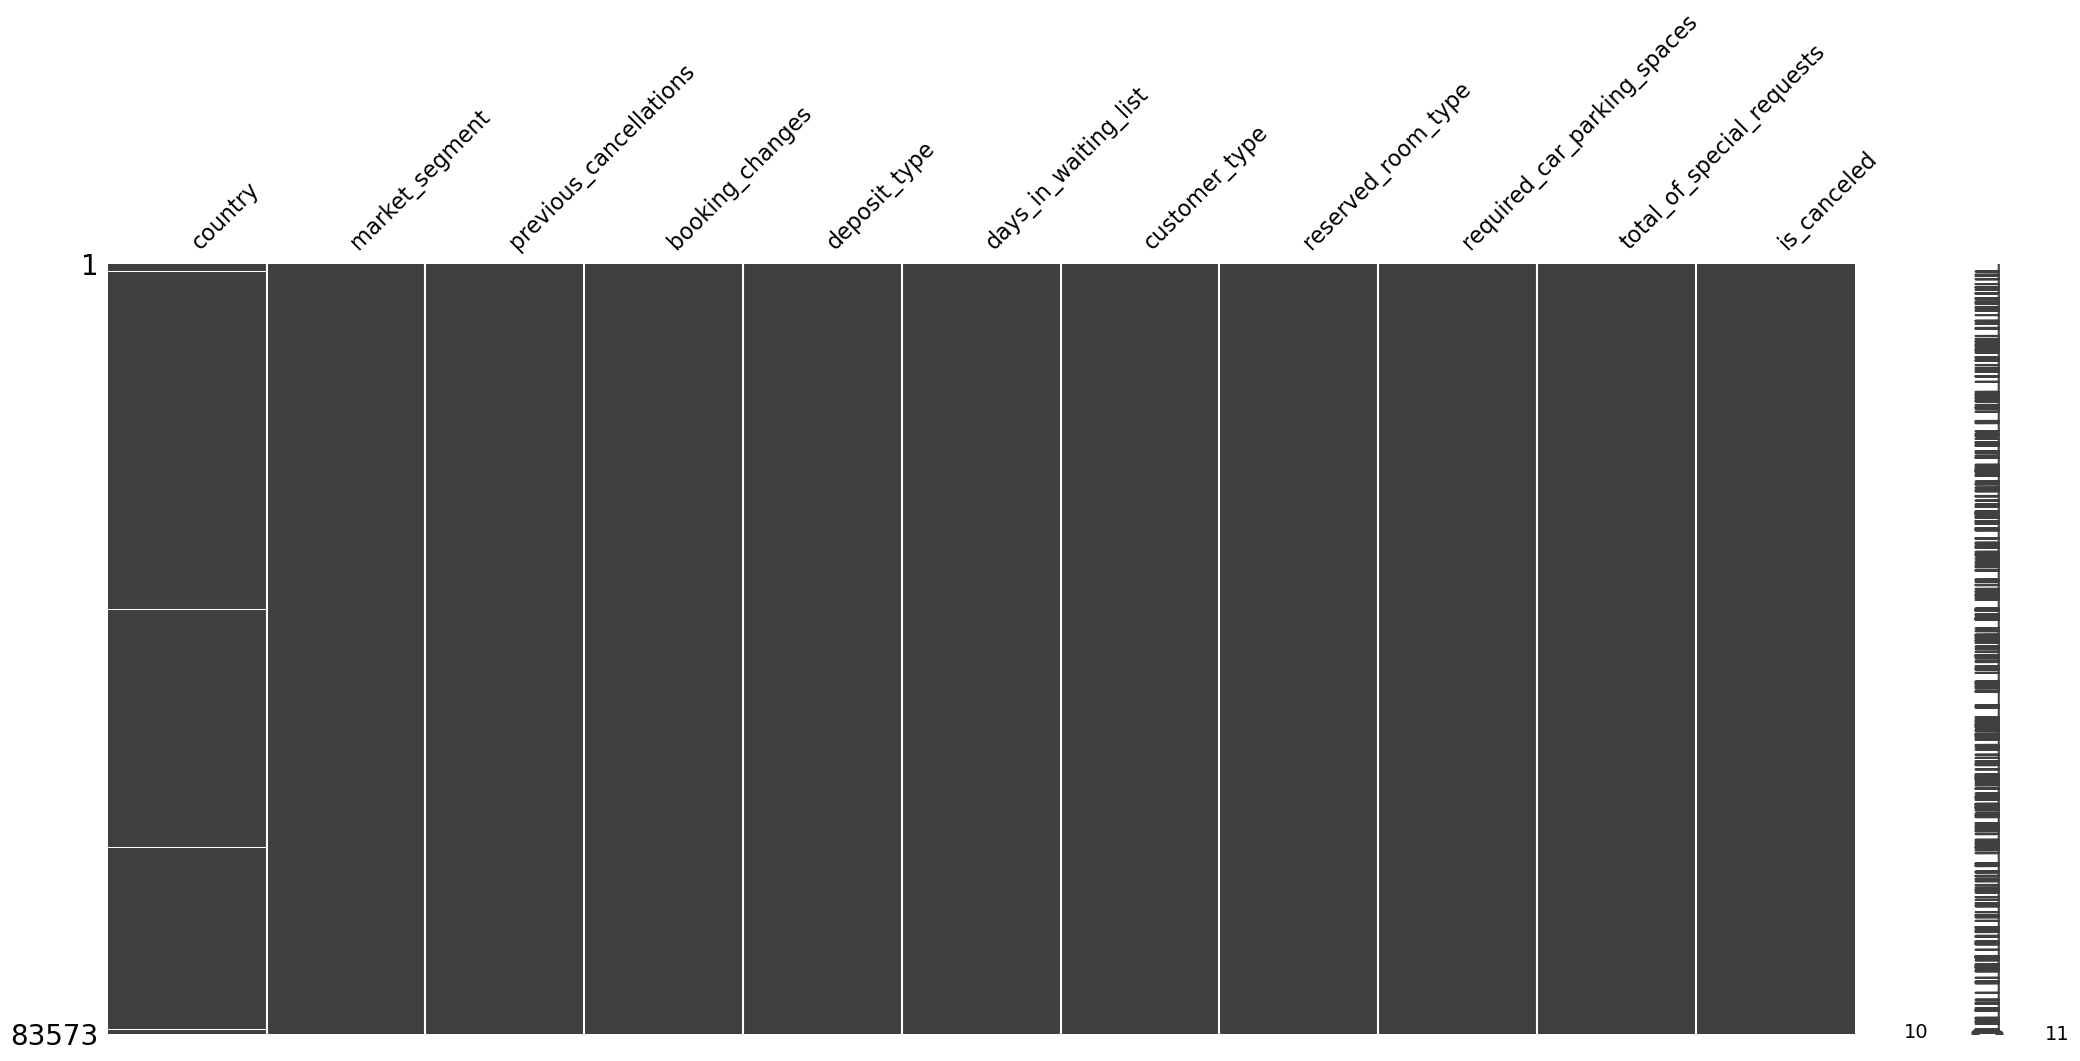

In [7]:
missingno.matrix(df_clean)

Terlihat bahwa missing value/data yang hilang pada setiap kolom country memiliki pola yang cukup unik.

## Menangani Missing Value

Untuk menangani missing value ada beberapa cara yang pertama kita lihat proporsi missing value tersebut

In [8]:
total_rows = len(df_clean)
missing_percentage = ((df_clean['country'].isna().sum()) / total_rows) * 100
print(f"Missing value di 'country': {missing_percentage:.2f}%")

Missing value di 'country': 0.42%


Berdasarkan dari perhitungan diatas, persentasi jumlah missing value di kolom country hanya 0.42% atau kurang dari 5%. hal ini bisa **dipertimbangkan untuk di drop** atau dihapus baris dengan missing value.
Hal ini berdasarkan logika bahwa jika data kurang dari 5% bisa dipetimbangkan sedangkan jika lebih dari 5% perlu dihindari untuk drop data karena bisa mengurangi jumlah data yang signifikan.

Selanjutnya, sebelum kita melakukan drop missing value ada baiknya kita mengecek apakah missing value di `country` berkorelasi dengan fitur lain atau target (`is_canceled`)

In [9]:
# Cek korelasi antara missing value di Country dan pembatalan
df_clean.groupby(df_clean['country'].isnull())['is_canceled'].mean()

country
False    0.369277
True     0.131054
Name: is_canceled, dtype: float64

Melihat dari hasil korelasi tersebut:
- ketika data negara tidak hilang, sekitar 36.9% reservasi dibatalkan
- ketika data negara hilang, hanya sekitar 13.1% reservasi dibatalkan

yang berarti missing value di kolom `country` memiliki nilai informasi prediktif:
- data dengan `country` hilang cenderung lebih jarang membatalkan pesanan dibandingkan dengan `country` lengkap.
- sehingga jika kita menghapus baris dengan missing value di kolom `country`, kita akan kehilangan pola ini, dan kemungkinan merusak performa model.

Oleh sebab itu untuk menangani hal ini kita akan **mengisi missing value** dengan **modus** (nilai yang paling banyak muncul). Modus **dipilih** karena salah satu pilihan yang masuk akal untuk data kategorikal, dan tetap mempertahankan distribusi dominan.

### Mengisi missing value dengan modus

In [10]:
most_common_country = df_clean['country'].mode()[0]
df_clean['country'].fillna(most_common_country, inplace=True)

In [11]:
## cek data yang sudah diganti
df_clean['country'].isna().sum()

0

Untuk benar-benar yakin bahwa missing value di kolom country ini signifikan, kita akan melakukan validasi menggunakan uji statistik (Chi-Square Test).

In [12]:
## membuat tabel kontingensi
contingency_table = pd.crosstab(df['country'].isna(), df['is_canceled'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square: {chi2}, p-value: {p:.22f}")

Chi-Square: 84.23929786219783, p-value: 0.0000000000000000000438


jadi hasil uji statistik diatas terlihat bahwa nilai missing yang ada di kolom country ini memiliki hubungan signifikan dengan pembatalan. hal ini bisa dilihat dari p-value yang kurang dari (<) 0.05. sehingga lebih baik nilai missing ini **dipertahankan** seperti yang telah kita lakukan di atas dengan mengisinya dengan nilai modus.

## Cek Duplikat

In [13]:
# cek duplikat 
df_clean.duplicated().sum()

73476

In [14]:
# persentase duplikat
duplicated_percentage = ((df_clean.duplicated().sum()) / len(df)) * 100
print(f"Persentase duplicated value : {duplicated_percentage:.2f}%")

Persentase duplicated value : 87.92%


In [15]:
df_clean.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Berdasarkan pengecekan diatas terdapat **73476 baris** yang duplikat atau sekitar **87.92%** yang duplikat.
hal ini mungkin bisa terjadi karena tidak ada id pelanggan yang membedakan pada dataframe. sehingga persentase duplikatnya sangat besar. oleh sebab itu **data duplikat** ini akan **dipertahankan** karena belum jelas apakah memang data tersebut duplikat atau bukan.

### Pengecekan Imbalance (Distribusi data target)

In [16]:
df_clean['is_canceled'].value_counts()

is_canceled
0    52795
1    30778
Name: count, dtype: int64

In [17]:
pd.crosstab(df_clean['is_canceled'], columns='count', normalize=True)*100

col_0,count
is_canceled,
0,63.172316
1,36.827684


Terlihat dari hasil pengecekan data imbalance diatas, walaupun tidak ada yang mencapai 75% namun data target terlihat sedikit imbalanced

#### Pengecekan Numerical Features Distribution

In [18]:
df_clean.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [19]:
df_clean.dropna().describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


#### Categorical Features Distribution

In [20]:
df_clean.describe(include=['O'])

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34448,39460,73352,62732,60041


In [21]:
df_clean.dropna().describe(include=['O'])

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34448,39460,73352,62732,60041


Terlihat dari distribusi baik yang numerikal maupun kategorikal sudah tidak ada data yang kosong.

In [22]:
listItem = []
for col in df_clean.columns :
    listItem.append([col, df_clean[col].dtype, df_clean[col].isna().sum(), round((df_clean[col].isna().sum()/len(df_clean[col])) * 100,2),
                    df_clean[col].nunique(), list(df_clean[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[AUS, SLV]"
1,market_segment,object,0,0.0,8,"[Undefined, Online TA]"
2,previous_cancellations,int64,0,0.0,15,"[3, 26]"
3,booking_changes,int64,0,0.0,19,"[21, 20]"
4,deposit_type,object,0,0.0,3,"[Refundable, No Deposit]"
5,days_in_waiting_list,int64,0,0.0,115,"[34, 120]"
6,customer_type,object,0,0.0,4,"[Transient, Transient-Party]"
7,reserved_room_type,object,0,0.0,10,"[A, H]"
8,required_car_parking_spaces,int64,0,0.0,5,"[8, 3]"
9,total_of_special_requests,int64,0,0.0,6,"[0, 3]"


In [23]:
print("Setelah dilakukan data cleaning, mari kita lihat: ")
print(f"Bentuk data setelah dibersihkan: {df_clean.shape}")
print("Kolom yang tersisa untuk modeling:")
print(df_clean.columns.tolist())

Setelah dilakukan data cleaning, mari kita lihat: 
Bentuk data setelah dibersihkan: (83573, 11)
Kolom yang tersisa untuk modeling:
['country', 'market_segment', 'previous_cancellations', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'reserved_room_type', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']


Okay, terlihat bahwa kolom country sudah tidak memiliki data yang kosong (null).

Dengan ini kita sudah memiliki data yang sudah bersih, mari sekarang kita lanjut ke tahap Analisis datanya sesuai dengan problem statement di awal.

## Data Analysis

### Feature Selection berdasarkan Domain Knowladge

Kita akan menghapus (drop) kolom yang tidak relevant seperti kolom `booking_changes` dan `reserved_room_type`.
kedua kolom tersebut kita hapus karena:
- `booking_changes` : potensi data leakage --> karena kemungkinan besar perubahan terjadi setelah booking, dan bisa dipengaruhi oleh pembatalan itu sendiri.
- `reserved_room_type` :  potensi leakage --> selain itu data pada kolom ini berupa kode anonim (A, B, C, ...), tidak menjelaskan jenis kamar dan sulit untuk diinterpretasikan tanpa dokumen tambahan.

In [24]:
df_clean.drop(columns=['booking_changes', 'reserved_room_type'], inplace=True)

In [25]:
df_clean.head()

,country,market_segment,previous_cancellations,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,No Deposit,0,Transient-Party,0,0,0
1,FRA,Online TA,0,No Deposit,0,Transient,0,2,0
2,PRT,Online TA,0,No Deposit,0,Transient,0,2,0
3,NLD,Online TA,0,No Deposit,0,Transient,0,1,1
4,PRT,Online TA,0,No Deposit,0,Transient,0,2,0


### Features Selection menggunakan EDA

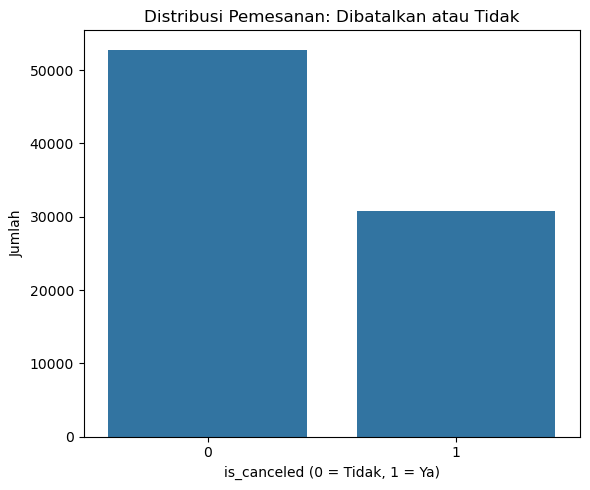

In [26]:
## melihat distribusi taget variabel: is_canceled
plt.figure(figsize=(6,5))
sns.countplot(x='is_canceled', data=df_clean)
plt.title('Distribusi Pemesanan: Dibatalkan atau Tidak')
plt.xlabel('is_canceled (0 = Tidak, 1 = Ya)')
plt.ylabel('Jumlah')
plt.tight_layout() 
plt.show()

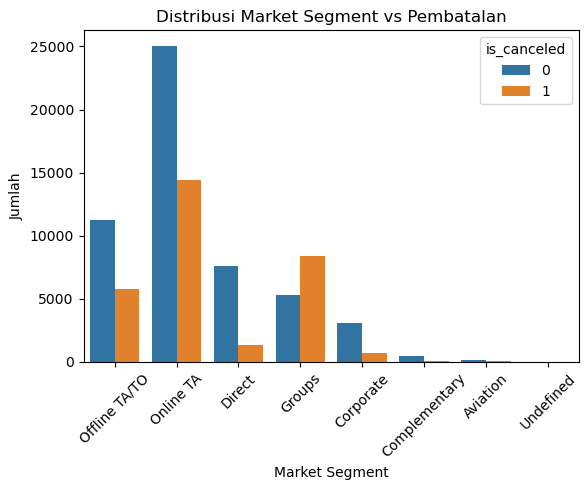

In [27]:
# Distribusi Market Segment vs Pembatalan
plt.figure(figsize=(6,5))
sns.countplot(x='market_segment', hue='is_canceled' , data=df_clean)
plt.title('Distribusi Market Segment vs Pembatalan')
plt.xlabel('Market Segment')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

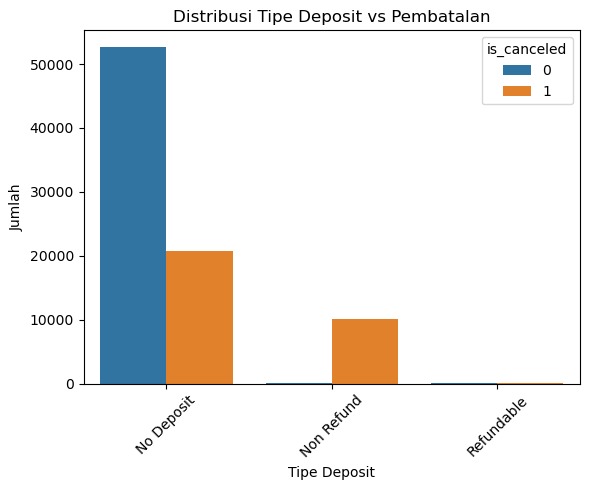

In [28]:
# Distribusi Tipe Deposit vs Pembatalan
plt.figure(figsize=(6,5))
sns.countplot(x='deposit_type', hue='is_canceled' , data=df_clean)
plt.title('Distribusi Tipe Deposit vs Pembatalan')
plt.xlabel('Tipe Deposit')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

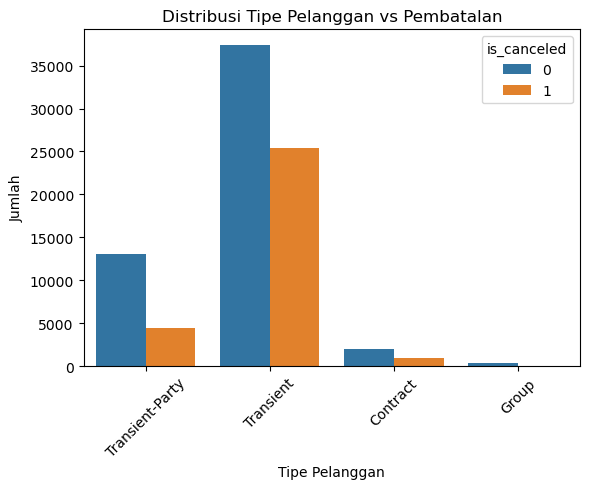

In [29]:
# Distribusi Tipe Pelanggan vs Pembatalan
plt.figure(figsize=(6,5))
sns.countplot(x='customer_type', hue='is_canceled' , data=df_clean)
plt.title('Distribusi Tipe Pelanggan vs Pembatalan')
plt.xlabel('Tipe Pelanggan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

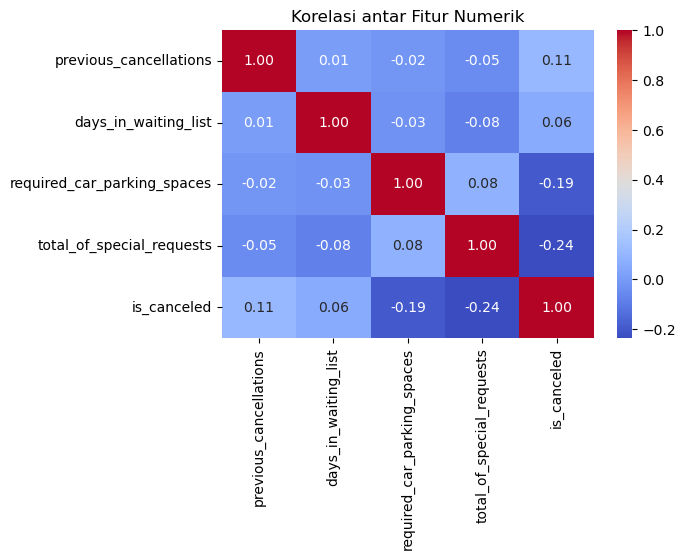

In [30]:
# Korelasi antar fitur numerik
plt.figure(figsize=(6,4))
corr_matrix = df_clean.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Korelasi antar Fitur Numerik')
plt.show()

Berdasarkan heatmap korelasi di atas, bisa kita lihat korelasi `is_canceled` atau target dengan kolom numerik lainnya:
- `previous_cencellations` memiliki korelasi 0.11 berarti ada sedikit kecenderungan jika pernah membatalkan sebelumnya lebih mungkin akan membatalkan lagi
- `day_in_waiting_list` memiliki korelasi 0.06 berarti korelasi sangat lemah, hampir tidak relevan
- `required_car_parking_spaces` memiliki korelasi -0.19 berarti korelasi negatif: tamu yang butuh parkir cenderung tidak membatalkan pesanan
- `total_of_special_requests` memiliki korelasi -0.24 berarti semakin banyak permintaan khusus, semakin kecil kemungkinan untuk melakukan pembatalan

bisa disimpulkan bahwa:
- fitur `total_of_special_requests` dan `required_car_parking_spaces` memiliki korelasi negatif signifikan ringan -> bisa berguna untuk model prediksi
- Korelasinya kecil karena pembatalan dipengaruhi banyak faktor non-linear, jadi model ML non-linear (seperti random forest) cocok digunakan nanti.

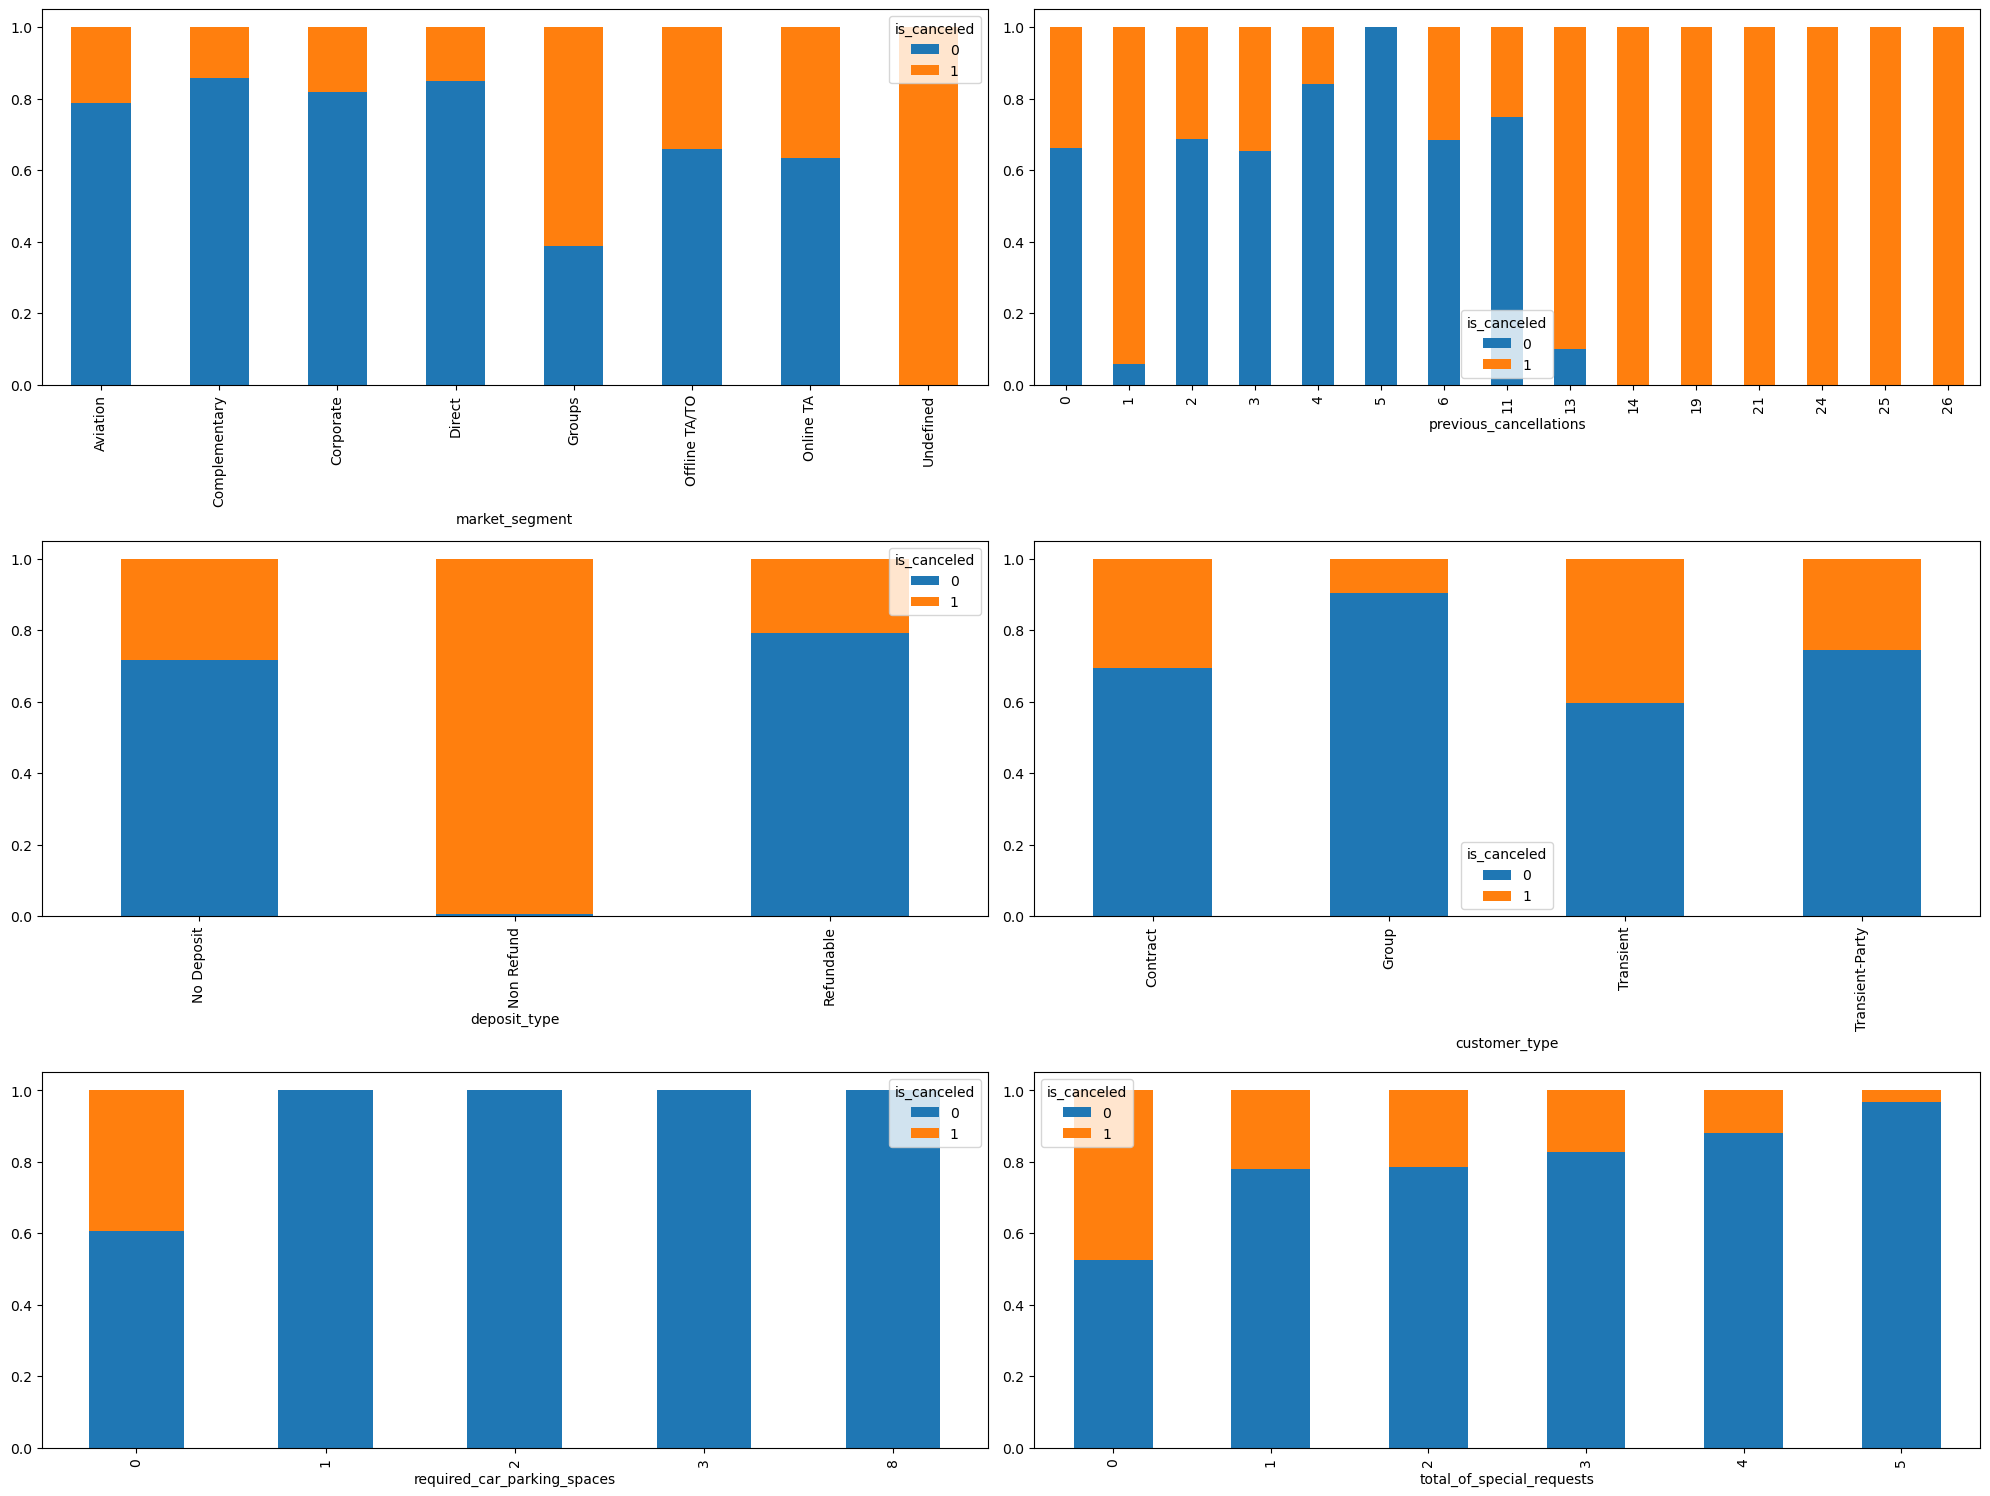

In [31]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_clean.drop(columns=['is_canceled','country','days_in_waiting_list']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df_clean[i],df_clean['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [32]:
for i in df_clean.drop(columns=['is_canceled', 'country']).columns:
    group_df = df_clean.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    display(group_df.sort_values(by=[1.0], ascending=False))

is_canceled,0,1
market_segment,,
Undefined,NaN,1.000000
Groups,0.386925,0.613075
Online TA,0.634237,0.365763
Offline TA/TO,0.659853,0.340147
Aviation,0.787879,0.212121
Corporate,0.819093,0.180907
Direct,0.848618,0.151382
Complementary,0.857143,0.142857


is_canceled,0,1
previous_cancellations,,
14,NaN,1.000000
19,NaN,1.000000
21,NaN,1.000000
24,NaN,1.000000
25,NaN,1.000000
26,NaN,1.000000
1,0.056572,0.943428
13,0.100000,0.900000
3,0.652174,0.347826


is_canceled,0,1
deposit_type,,
Non Refund,0.006231,0.993769
No Deposit,0.717704,0.282296
Refundable,0.790909,0.209091


is_canceled,0,1
days_in_waiting_list,,
391,NaN,1.0
71,NaN,1.0
79,NaN,1.0
26,NaN,1.0
76,NaN,1.0
...,...,...
121,1.0,NaN
150,1.0,NaN
185,1.0,NaN


is_canceled,0,1
customer_type,,
Transient,0.595645,0.404355
Contract,0.692922,0.307078
Transient-Party,0.744183,0.255817
Group,0.903073,0.096927


is_canceled,0,1
required_car_parking_spaces,,
0,0.607153,0.392847
1,1.000000,NaN
2,1.000000,NaN
3,1.000000,NaN
8,1.000000,NaN


is_canceled,0,1
total_of_special_requests,,
0,0.524904,0.475096
1,0.780047,0.219953
2,0.784320,0.215680
3,0.827915,0.172085
4,0.881356,0.118644
5,0.967742,0.032258


Berdasarkan barplot dan table diatas kita dapat menyimpulkan beberapa hal :
1. Pelanggan yang berasal dari `market_segment`nya `undefined` lebih cenderung akan membatalakan bookingan dibandingkan dengan `market_segment` yang lain.
2. Pelanggan yang `previous_cancellations`nya `>14` lebih cenderung akan membatalakan bookingan dibandingkan `previous_cancellations` yang lain.
3. Pelanggan yang `deposit_type`nya `Non Refund` lebih cenderung akan membatalakan bookingan dibandingkan `deposit_type` yang lain.
4. Pelanggan yang `customer_type`nya `Transient` lebih cenderung akan membatalakan bookingan dibandingkan `customer_type` yang lain.
5. Pelanggan yang `days_in_waiting_list` nya `391` lebih cenderung akan membatalkan bookingan dibandingkan `days_in_waiting_list` yang lain.
6. Pelanggan yang `required_car_parking_spaces` nya `0` biasanya lebih cenderung akan membatalakan bookingan dibandingkan `required_car_parking_spaces` yang lain.
7. Pelanggan yang `total_of_special_requests`nya `0` lebih cenderung akan membatalakan bookingan dibandingkan `total_of_special_requests` yang lain.

Sekarang mari kita lihat juga untuk kolom country, apakah terlihat perbedaan kecenderungan pembatalan booking antara pelanggan dari negara yang berbeda.

In [33]:
country_df = df_clean.groupby('country')['is_canceled'].value_counts(normalize=True).unstack()
country_df['count'] = df_clean.groupby('country')['is_canceled'].count()
display(country_df.sort_values(by=[1.0], ascending=False).head(15))
display(country_df.sort_values(by=[1.0], ascending=False).tail(15))

is_canceled,0,1,count
country,,,
IMN,NaN,1.000000,2
NIC,NaN,1.000000,1
MYT,NaN,1.000000,1
MAC,NaN,1.000000,8
KHM,NaN,1.000000,2
JEY,NaN,1.000000,7
BHR,NaN,1.000000,4
SYC,NaN,1.000000,1
BEN,NaN,1.000000,1


is_canceled,0,1,count
country,,,
MWI,1.0,NaN,2
NCL,1.0,NaN,1
PAN,1.0,NaN,8
PLW,1.0,NaN,1
PRY,1.0,NaN,3
RWA,1.0,NaN,1
SDN,1.0,NaN,1
SLE,1.0,NaN,1
SLV,1.0,NaN,2


Terlihat dari table diatas, bahwa ada perbedaan kecenderungan pembatalan dari pelanggan dari negara yang berbeda.

Mari kita lihat kecenderungan 5 negara dengan jumlah pelanggan terbanyak.

In [34]:
df_clean['country'].value_counts()

country
PRT    34448
GBR     8495
FRA     7307
ESP     5996
DEU     5116
       ...  
ZMB        1
LCA        1
SYC        1
GLP        1
AIA        1
Name: count, Length: 162, dtype: int64

In [35]:
# Persentase
(pd.crosstab(df_clean['country'], columns='count', normalize=True)*100).sort_values('count', ascending=False)

col_0,count
country,
PRT,41.219054
GBR,10.164766
FRA,8.743254
ESP,7.174566
DEU,6.121594
...,...
SYC,0.001197
LCA,0.001197
SLE,0.001197


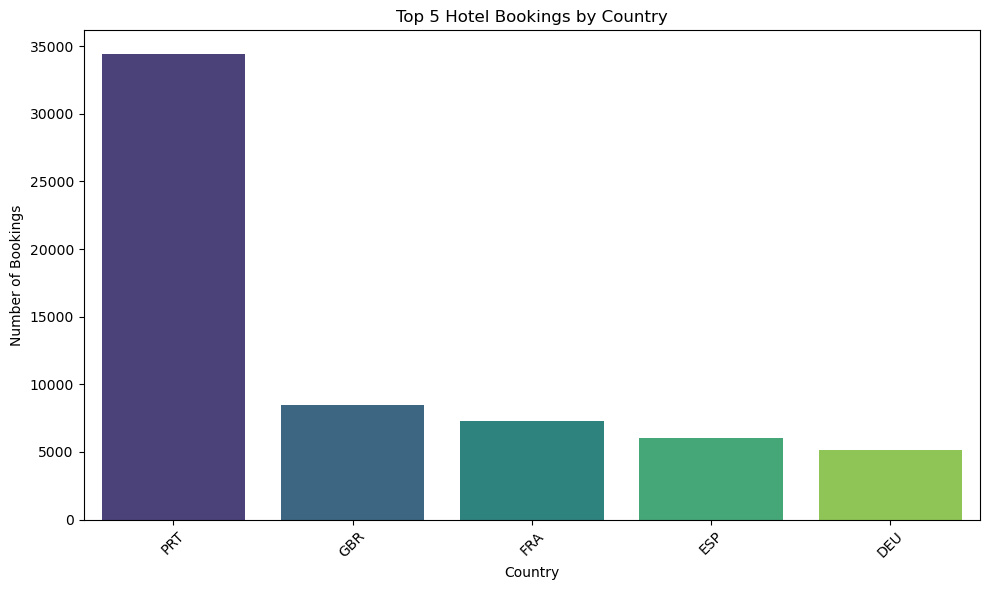

In [36]:
# Plot bar chart 5 Negara asal pelanggan terbanyak
plt.figure(figsize=(10, 6))
sns.barplot(x=df_clean['country'].value_counts().head().index, y=df_clean['country'].value_counts().head().values, palette='viridis')

# Tambahkan label dan judul
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.title('Top 5 Hotel Bookings by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Pelanggan dari negara `PRT` atau Portugal merupakan pelanggan terbanyak dari data hotel ini. tidak heran karena data hotel ini berasal dari hotel di Portugal. pelanggan dari Portugal menyumbang **41.21%** dari total keselurugan pelanggan.
- Negara kedua yaitu `GBR` atau Inggris menyumbang sebesar **10.16%** dari total pelangggan.
- Negara dengan total pelanggan terbanyak ketiga yaitu `FRA` atau Prancis meyumbang **8.74 %**.
- Negara keempat penyumbang pelanggan terbanyak yaitu `ESP` atau Spanyol dengan persentase sebesar **7.17%**.
- Negara `DEU` atau Jerman merupakan negara kelima penyumbang pelanggan terbesar dengan persentase **6.12%**.

In [37]:
country_df.sort_values(by=[1.0], ascending=False).loc['PRT']

is_canceled
0            0.442551
1            0.557449
count    34448.000000
Name: PRT, dtype: float64

In [38]:
country_df.sort_values(by=[1.0], ascending=False).loc['GBR']

is_canceled
0           0.797057
1           0.202943
count    8495.000000
Name: GBR, dtype: float64

In [39]:
country_df.sort_values(by=[1.0], ascending=False).loc['FRA']

is_canceled
0           0.813056
1           0.186944
count    7307.000000
Name: FRA, dtype: float64

In [40]:
country_df.sort_values(by=[1.0], ascending=False).loc['ESP']

is_canceled
0           0.742161
1           0.257839
count    5996.000000
Name: ESP, dtype: float64

In [41]:
country_df.sort_values(by=[1.0], ascending=False).loc['DEU']

is_canceled
0           0.835027
1           0.164973
count    5116.000000
Name: DEU, dtype: float64

Terlihat bahwa `GBR`, `FRA`, `ESP` dan `DEU` memiliki kecenderungan pelanggan yang mirip, dimana jauh lebih banyak yang tidak membatalkan booking dibandingkan yang membatalkan, sedangkan untuk `PRT` lebih banyak pelanggan yang membatalkan booking dibandingkan yang tidak membatalkan booking walaupun selisihnya tidak terlalu jauh.

selanjutnya kita kan lihat berdasarkan benuanya.

## Feature Engineering

#### Pengelompokkan Negara Kedalam Benua

Fiture engineering ini dilakukan untuk melihat lebih jauh apakah asal benua berpengaruh dalam cancelasi booking.

In [42]:
df_clean['country'].unique()

array(['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA',
       'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL',
       'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS',
       'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN',
       'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY',
       'ISR', 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY',
       'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA',
       'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN',
       'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN',
       'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS',
       'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC',
       'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR',
       'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA',
       'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM',
       'KWT', 'LAO', 

In [43]:
# Pemetaan negara
import pycountry
import pycountry_convert as pc

# Fungsi konversi ISO-3 → ISO-2 → kode benua → nama benua
def iso3_to_continent(country_code):
    try:
        if pd.isna(country_code):  # Lewati NaN
            return 'Other'

        country_code = country_code.strip().upper()

        # Coba cari berdasarkan ISO-3 dulu
        country = pycountry.countries.get(alpha_3=country_code)
        
        if not country:
            # Kalau gagal, coba cari sebagai ISO-2
            country = pycountry.countries.get(alpha_2=country_code)
        
        if country:
            alpha2 = country.alpha_2
            continent_code = pc.country_alpha2_to_continent_code(alpha2)
            return pc.convert_continent_code_to_continent_name(continent_code)
        else:
            return 'Other'
    
    except Exception as e:
        return 'Other'

# Terapkan fungsi pada kolom 'country'
df_clean['country_bin'] = df_clean['country'].apply(iso3_to_continent)

# Lihat hasil distribusinya
df_clean['country_bin'].value_counts()

country_bin
Europe           75850
Asia              3115
South America     1891
North America     1593
Africa             767
Oceania            353
Other                4
Name: count, dtype: int64

In [44]:
df_clean['country_bin'].isnull().sum()

0

In [45]:
df_clean[df_clean['country_bin'] == 'Other']

,country,market_segment,previous_cancellations,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,is_canceled,country_bin
8,UMI,Online TA,0,No Deposit,0,Transient,0,1,1,Other
2054,ATA,Direct,0,No Deposit,0,Transient,0,0,0,Other
36387,TMP,Online TA,0,No Deposit,0,Transient,0,2,0,Other
66975,TMP,Online TA,0,No Deposit,0,Transient,1,3,0,Other


In [46]:
## Persentase Asal Benua Pelanggan
(pd.crosstab(df_clean['country_bin'], columns='count', normalize=True)*100).sort_values('count', ascending=False)

col_0,count
country_bin,
Europe,90.758977
Asia,3.727280
South America,2.262692
North America,1.906118
Africa,0.917761
Oceania,0.422385
Other,0.004786


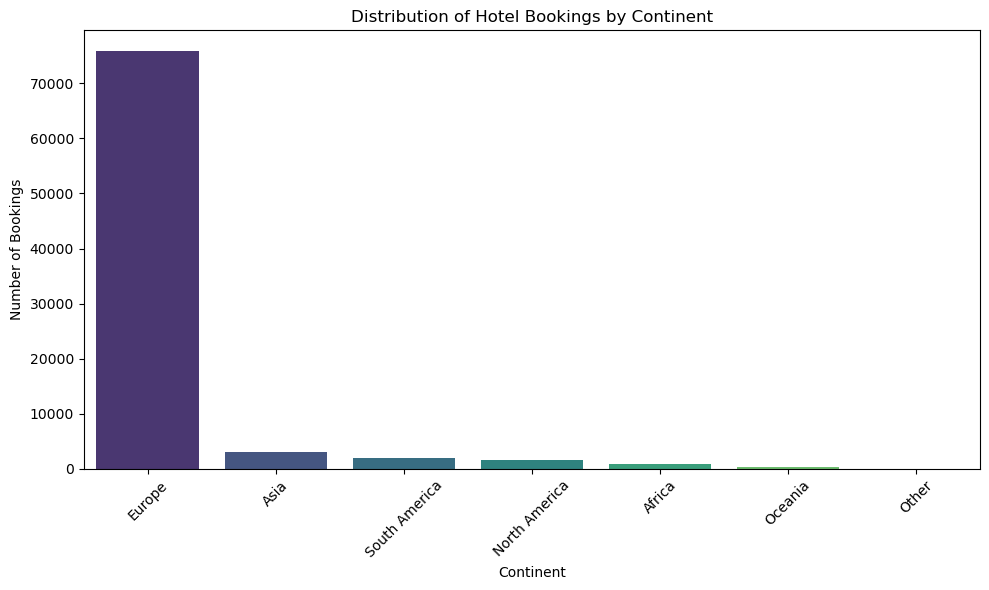

In [47]:
# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=df_clean['country_bin'].value_counts().index, y=df_clean['country_bin'].value_counts().values, palette='viridis')

# Tambahkan label dan judul
plt.xlabel('Continent')
plt.ylabel('Number of Bookings')
plt.title('Distribution of Hotel Bookings by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Berdasarkan analisis tersebut terlihat bahwa jumlah pelanggan dari benua Eropa dengan total 75850 pelanggan atau sebesar 91.73% dari total pelannggan.

In [48]:
## melihat persentase pelanggan yang membatalkan pesanan berdasarkan benua

In [49]:
df_clean[['country_bin', 'is_canceled']].groupby('country_bin').mean()*100

,is_canceled
country_bin,
Africa,42.633638
Asia,32.391653
Europe,37.330257
North America,23.289391
Oceania,22.379603
Other,25.000000
South America,35.748281


Pelanggan yang berasal dari Afrika cenderung akan membatalkan pesanan mereka dibandingkan dengan pelanggan dari benua lain.

### Pengelompokan Fiture `days_in_waiting_list`

Feature engineering ini dilakukan untuk mengubah angka hari menjadi kategori yang mudah diinterpretasi dan relevan dengan perilaku pembatalan, seperti:
- Apakah semakin lama menunggu, semakin besar kemungkinan cancel?
- Apakah ada threshold tertentu yang memengaruhi keputusan pelanggan?
untuk itu mari kita lihat distribusinya terlebih dahulu sebelum menentukan treshold binning kita.

In [50]:
df_clean['days_in_waiting_list'].describe()

count    83573.000000
mean         2.330561
std         17.673051
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        391.000000
Name: days_in_waiting_list, dtype: float64

Berdasarkan data diatas kita mendaftakan insight:
- 75% data memiliki nilai 0 -> sebagian besar tamu tidak mengalami waktu tunggu.
- Rata-rata hanya 2.3 hari, tapi standar deviasi sangat tinggi (17.67) -> ada outlier ekstrem (sampai 391 hari).
- Hanya sebagian kecilt ama menunggu >0 hari.

Karena mayoritas datanya bernilai 0 , dan jumlah tamu dengan waiting time >0 relatif sedikit, kita bisa membuat kategori yang mencerminkan signifikansi perilaku :
- **No Waiting** : 0 hari --> Tidak ada waktu tunggu
- **Short Waiting** : 1-3 hari --> Menunggu singkat, mungkin masih fleksible
- **Medium Waiting** : 4-14 hari --> Menunggu cukup lama, sudah mulai ragu
- **Long Waiting** : >30 hari --> Menunggu terlalu lama, risiko pembatalan tingggi

In [51]:
# Definisikan bins dan labels
bins = [-1, 0, 3, 14, float('inf')]
labels = ['No Waiting', 'Short Waiting', 'Medium Waiting', 'Long Waiting']

# Buat kolom baru
df_clean['waiting_category'] = pd.cut(df_clean['days_in_waiting_list'], bins=bins, labels=labels)

In [52]:
## Melihat validasi
df_clean.groupby('waiting_category')['is_canceled'].mean()

waiting_category
No Waiting        0.359522
Short Waiting     0.860000
Medium Waiting    0.470588
Long Waiting      0.644082
Name: is_canceled, dtype: float64

Berdasarkan data diatas, terdapat hal yang menarik perhatian karena dalam kategori `short_waiting` memiliki cancel rate tertinggi. dari analisis tersebut 86% tamu yang menunggu 1-3 hari akhirnya membatalkkan reservasi.

Kita akan melihat lebih jauh `waiting_category` ini.

In [53]:
df_clean.groupby('waiting_category')[['market_segment', 'customer_type']].agg(lambda x: x.value_counts().index[0])

,market_segment,customer_type
waiting_category,,
No Waiting,Online TA,Transient
Short Waiting,Offline TA/TO,Transient
Medium Waiting,Groups,Transient-Party
Long Waiting,Offline TA/TO,Transient


In [54]:
df_clean.pivot_table(index='market_segment', columns='waiting_category', values='is_canceled', aggfunc='mean')

waiting_category,No Waiting,Short Waiting,Medium Waiting,Long Waiting
market_segment,,,,
Aviation,0.212121,NaN,NaN,NaN
Complementary,0.143418,NaN,0.000000,0.000000
Corporate,0.180415,0.000000,0.000000,0.266667
Direct,0.151406,1.000000,0.000000,0.000000
Groups,0.619255,0.000000,0.543860,0.542689
Offline TA/TO,0.303501,0.954545,0.428571,0.728315
Online TA,0.365747,NaN,NaN,1.000000
Undefined,1.000000,NaN,NaN,NaN


Terlihat bahwa jumlah tamu yang No Waiting berdasarkan market_segment lebih banyak dari Online TA dan jenis tamu Transiet.
Sedangkan Undefined memiliki rata-rata is_canceled terbesar di kategori No Waitiing.

Fitur waiting_category bisa menjadi fitur yang sangat informatif, terutama kategori "Short Waiting" sebagai flag resiko cancel sangat tinggi.

### Binary Flag Fiture `previous_cancellations`

Feature engineering ini dilakukan untuk:
- Mudah diinterpretasi
  Model bisa lebih mudah memahami apakah seseorang "pernah batal" atau tidak, daripada harus memproses angka spesifik seperti 1, 2, 5 kali pembatalan.
- Memodel prilaku kategoris
  Dalam banyak kasus, hanya tahu "pernah batal" vs "tidak pernah batal" sudah cukup untuk menangkap pola risiko pembatalan.
- Menghindari outlier
  Jika ada tamu dengan `previous_cancellations` = 100, itu bisa jadi outlier dan mengganggu model jika dibiarkan sebagai numerik mentah. Binary flag menghindari hal ini.

In [55]:
df_clean['has_previous_cancellation'] = df_clean['previous_cancellations'].apply(lambda x: 1 if x > 0 else 0)

In [56]:
df_clean.groupby('has_previous_cancellation')['is_canceled'].mean()

has_previous_cancellation
0    0.337086
1    0.914691
Name: is_canceled, dtype: float64

terlihat dari analisis diatas, tamu yang memiliki riwayat pembatalan lebih cenderung membatalakan pesanan.

### Pengelompokkan Fiture `previous_cancellations`

Feature engineering ini dilakukan untuk:
- Menangkap non-linearitas
  Hubungan antara jumlah pembatalan sebelumnya dan probabilitas cancel saat ini mungkin tidak linear. Misal: orang yang 1x batal ≠ setengah dari yang 2x batal.
- Lebih stabil secara statistik
  Kelompok memberikan representasi lebih stabil dibandingkan angka mentah, terutama jika distribusi data tidak normal atau ada noise.
- Menghindari overfitting pada angka jarang
  Misal: sangat sedikit tamu yang punya 10x pembatalan. Dengan grouping, semua yang >3 bisa digabung jadi satu grup.
- Lebih mudah dijelaskan ke stakeholder
Lebih mudah bilang "tamu dengan 1-3 pembatalan sebelumnya lebih berisiko" daripada "setiap peningkatan 1x pembatalan meningkatkan risiko sebesar X%".

In [57]:
# Binning
bins = [-1, 0, 3, float('inf')]
labels = ['0', '1-3', '4+']
df_clean['prev_cancel_group'] = pd.cut(df_clean['previous_cancellations'], bins=bins, labels=labels)

In [58]:
df_clean.groupby('prev_cancel_group')['is_canceled'].mean()

prev_cancel_group
0      0.337086
1-3    0.924637
4+     0.666667
Name: is_canceled, dtype: float64

terlihat bahwa tamu yag berada dalam kelompok yg pernah cancelasi 1-3 kali lebih mungkin membatalkan pesanan dibandingkand dengan tamu lainnya.

### Binary Flag Fiture `required_car_parking_spaces`

Feature engineering ini dilakukan untuk:
- Bisa jadi indikator bahwa tamu datang dengan mobil → mungkin lebih sulit untuk cancel last minute.
- Model bisa lebih fokus pada ada/tidaknya kebutuhan parkir , bukan jumlah detailnya.

In [59]:
df_clean['needs_parking'] = (df_clean['required_car_parking_spaces'] > 0).astype(int)

In [60]:
df_clean.groupby('needs_parking')['is_canceled'].mean()

needs_parking
0    0.392847
1    0.000000
Name: is_canceled, dtype: float64

Terlihat bahwa orang yang tidak membutuhkan parking lebih cenderung untuk melakukan cancel. 

Sekarang mari kita siapkan data kita untuk pembuatan model machine learning.

## Data Preparation 

In [61]:
# Inspeksi data

In [62]:
df_clean.head()

,country,market_segment,previous_cancellations,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,is_canceled,country_bin,waiting_category,has_previous_cancellation,prev_cancel_group,needs_parking
0,IRL,Offline TA/TO,0,No Deposit,0,Transient-Party,0,0,0,Europe,No Waiting,0,0,0
1,FRA,Online TA,0,No Deposit,0,Transient,0,2,0,Europe,No Waiting,0,0,0
2,PRT,Online TA,0,No Deposit,0,Transient,0,2,0,Europe,No Waiting,0,0,0
3,NLD,Online TA,0,No Deposit,0,Transient,0,1,1,Europe,No Waiting,0,0,0
4,PRT,Online TA,0,No Deposit,0,Transient,0,2,0,Europe,No Waiting,0,0,0


In [63]:
df_clean.isnull().sum()

country                        0
market_segment                 0
previous_cancellations         0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
country_bin                    0
waiting_category               0
has_previous_cancellation      0
prev_cancel_group              0
needs_parking                  0
dtype: int64

In [64]:
df_clean['is_canceled'].value_counts()

is_canceled
0    52795
1    30778
Name: count, dtype: int64

Terlihat ada class imbalance pada kolom target

Kita tidak akan memakai fitur country karena sudah ada fitur country_bin dengan alasan:
- Jumlah kategori banyak
    Kolom country biasanya punya puluhan hingga ratusan kategori (misal: 100+ negara), ini bisa menyulitkan model dan menyebabkan overfitting.
- Interpretasi Lebih Mudah
    country_bin mengelompokkan negara ke benua (Asia, Europe, dll), lebih mudah diinterpretasi dan berpotensi memiliki pola perilaku pembatalan yang mirip dalam satu kelompok.
- Performa Model Lebih Baik
    Dengan jumlah kategori lebih sedikit, risiko overfitting berkurang dan model bisa belajar pola lebih general.

Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Tidak Merubah fitur/kolom `country_bin` karena data ini sudah dalam bentuk ordinal.
2. Merubah fitur/kolom `market_segment` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `deposit_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `customer_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
5. Merubah fitur `previous_cancellations`, `days_in_waiting_list`, `required_car_parking_spaces` dan `total_of_special_requests` kita gunakan StandardScaler, karena fitur ini sudah dalam bentuk numerik.
6. Merubah fitur `waiting_category` dan `prev_cancel_group` menggunakan One Hot Encoding, karena fitur tidak memiliki urutan dan juga jumlah unique datanay sedikit.
7. Tidak merubah fitur `has_previous_cancellation` dan `needs_parking` karena sudah numerik tidak perlu encoding tambahan.

#### Pisahkan Fitur dan Target

In [65]:
X = df_clean.drop('is_canceled', axis=1)
y = df_clean['is_canceled']

#### Split Data (Train-Test)

In [66]:
# Bagi data dengan stratifikasi untuk menjaga distribusi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # untuk menangani class imbalance
)

#### Preprocessing: Encoding dan Scaling

In [67]:
# Kolom asli
categorical_features = ['market_segment', 'deposit_type', 'customer_type']
numerical_features = ['previous_cancellations', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']

# Kolom hasil feature engineering
binary_flag_features = ['has_previous_cancellation', 'needs_parking']
binned_categorical_features = ['waiting_category', 'prev_cancel_group']
ordinal_encoded_features = ['country_bin']

# Transformer untuk preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_encoded_features),
        ('bin', 'passthrough', binary_flag_features),
        ('bin_cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), binned_categorical_features),
    ])

## Model & Evaluation

In [68]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### Model Benchmarking : K-Fold

In [69]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',preprocessor),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 19697, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 53486, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368265 -> initscore=-0.539669
[LightGBM] [Info] Start training from score -0.539669
[LightGBM] [Info] Number of positive: 19697, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 53486, number of used features: 28
[LightGBM] [Info] [b

,mean roc_auc,sdev
model,,
XGBoost,0.848127,0.005160
LightGBM,0.848122,0.005098
Random Forest,0.848026,0.004963
Decision Tree,0.847662,0.004941
Logistic Regression,0.829033,0.004086
KNN,0.790814,0.027449


Kesimpulan dari Cross-Validation:
- XGBoost memiliki ROC AUC tertinggi (0.848127) dengan standar deviasi rendah (0.005160), menunjukkan bahwa model ini stabil dan performa terbaik dalam cross-validation.
- LightGBM sangat dekat dengan XGBoost (0.848122), tetapi sedikit lebih rendah.
- Random Forest juga menunjukkan performa yang baik (0.848048).
- Decision Tree memiliki performa cukup baik (0.847655), tetapi sedikit lebih rendah dibandingkan tiga model sebelumnya.
- Logistic Regression memiliki performa yang lebih rendah (0.829033), tetapi masih relevan karena standar deviasinya rendah.
- KNN memiliki performa terendah (0.790814) dengan standar deviasi tinggi (0.027449), menunjukkan bahwa model ini kurang stabil dan tidak sesuai untuk kasus ini.

Namun bisa dilihat juga bahwa perbedaan antar model tidak lah terlalu jauh perbedaanya.

### Model Benchmarking : Test Data

In [70]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',preprocessor),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     10559
           1       0.78      0.62      0.69      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.76      0.77     16715
weighted avg       0.79      0.80      0.79     16715

KNN 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     10559
           1       0.59      0.78      0.67      6156

    accuracy                           0.72     16715
   macro avg       0.72      0.73      0.71     16715
weighted avg       0.75      0.72      0.73     16715

Decision Tree 
               precision    recall  f1-score   support

           0       0.80      0.90      0.85     10559
           1       0.79      0.61      0.69      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.76      0.77     16715
weighted avg       0.80      0

,roc_auc score
model,
XGBoost,0.846408
Random Forest,0.845989
LightGBM,0.845844
Decision Tree,0.845755
Logistic Regression,0.824788
KNN,0.799543


Kesimpulan dari Test Data:
- XGBoost masih menunjukkan ROC AUC tertinggi (0.846408) pada data test, meskipun nilai ini sedikit lebih rendah dibandingkan cross-validation. Ini menunjukkan bahwa model ini tetap stabil dan generalisasi dengan baik.
- LightGBM dan Random Forest juga menunjukkan performa yang sangat dekat (0.845844 dan 0.845807), tetapi sedikit lebih rendah dibandingkan XGBoost.
- Decision Tree memiliki performa yang hampir sama dengan LightGBM dan Random Forest (0.845755).
- Logistic Regression memiliki performa yang lebih rendah (0.824788), tetapi masih relevan.
- KNN memiliki performa terendah (0.799543), yang konsisten dengan hasil cross-validation.

### Analisis Perbandingan Model

1. Stabilitas dan Generalisasi:
    - XGBoost menunjukkan performa paling stabil antara cross-validation dan test data, dengan penurunan kecil (0.848127 → 0.846408). Ini menunjukkan bahwa model ini generalisasi dengan baik .
    - LightGBM , Random Forest , dan Decision Tree juga menunjukkan performa yang stabil, tetapi sedikit lebih rendah dibandingkan XGBoost.
    - Logistic Regression memiliki penurunan yang lebih signifikan (0.829033 → 0.824788), tetapi masih relevan.
    - KNN memiliki performa yang tidak stabil (0.790814 → 0.799543), tetapi tetap menunjukkan tren yang konsisten.
2. Performa Terbaik:
    - XGBoost tetap menjadi model terbaik berdasarkan kedua metrik (cross-validation dan test data).
3. Model yang Kurang Baik:
    - KNN memiliki performa yang rendah dan tidak stabil, sehingga kurang cocok untuk kasus ini.

Berdasarkan hal tersebut pilihan model utama yang akan dipakai adalah model ***XGBoost***.

Dengan pertimbangan:
- ROC-AUC tertinggi di kedua skenario:
    - K-Fold: 0.848127
    - Test Data: 0.846408
- Lebih robust untuk berbagai kasus karena:
    - Fitur importance otomatis.
    - Handle missing data & outliers lebih baik daripada LightGBM (tergantung data).
- Jika deploy ke production, XGBoost umumnya lebih stabil (tapi LightGBM lebih cepat training).

### Penjelasan Algoritma

XGBoost (Extreme Gradient Boosting): merupakan algoritma ensemble berbasis pohon keputusan yang menggunakan pendekatan boosting. XGBoost bekerja dengan membangun pohon keputusan secara bertahap, di mana setiap pohon baru dibentuk untuk memperbaiki kesalahan prediksi dari pohon sebelumnya. Model ini mengoptimalkan fungsi loss secara bertahap menggunakan metode gradient descent, sehingga hasil akhirnya sangat akurat dan efisien.

XGBoost juga dilengkapi fitur-fitur seperti:
- Regularisasi (untuk mencegah overfitting),
- Penanganan missing value secara otomatis,
- Paralelisasi dalam training (cepat dan efisien).

### Evaluation Metrics
- Digunakan metrik: Accuracy, Precision, Recall, F1-Score.
- Fokus pada **recall** karena penting bagi bisnis untuk meminimalisasi pembatalan yang tidak terdeteksi.

### Cek Classsification Report XGBoost

In [71]:
xgb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])

In [72]:
xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     10559
           1       0.79      0.61      0.69      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.76      0.77     16715
weighted avg       0.80      0.80      0.79     16715



### Cek Confussion Metrics XGBoost

In [73]:
cm = confusion_matrix(y_test, y_pred)

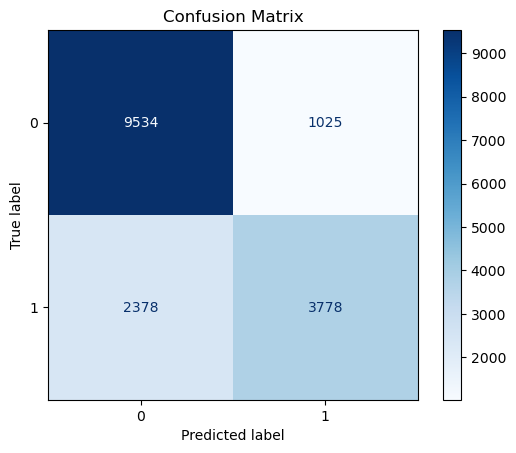

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= xgb_pipe.named_steps['model'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Analisis Performa per class

- Class 0 (Tidak Canceled - Mayoritas):
    - **Recall (Sensitivity) : 90%**
        - Model berhasil mengenali 90% dari semua kasus "tidak cancel" dengan benar.
        - Hanya 10% False Negative (FN) → Sedikit tamu yang seharusnya tidak dibatalkan tetapi diprediksi dibatalkan.
    - **Precision : 80%**
        - Dari semua prediksi "tidak cancel", 80% adalah benar .
        - Ada 20% False Positive (FP) → Beberapa tamu yang sebenarnya dibatalkan tetapi diprediksi tidak dibatalkan.
    - **F1-Score : 0.85**
        - Seimbangan antara precision dan recall, menunjukkan performa yang cukup baik untuk class ini.
- Class 1 (Canceled - Minoritas):
    - **Recall (Sensitivity) : 61%**
        - Model hanya mampu mengenali 61% dari semua kasus pembatalan dengan benar.
        - 39% False Negative (FN) → Banyak tamu yang sebenarnya dibatalkan tetapi tidak terdeteksi oleh model.
    - **Precision : 79%**
        - Dari semua prediksi "cancel", 79% adalah benar .
        - Ada 21% False Positive (FP) → Beberapa tamu yang sebenarnya tidak dibatalkan tetapi diprediksi dibatalkan.
    - **F1-Score : 0.69**
        - Performa lebih rendah dibandingkan class 0, karena recall yang lebih rendah.

✅ Berdasaran Confussion Matrix
- True Negative (TN): 9,534
    - Model dengan benar memprediksi bahwa 9,534 reservasi tidak dibatalkan , dan ternyata memang tidak dibatalkan.
- False Positive (FP): 1,025
    - Model salah memprediksi bahwa 1,025 reservasi dibatalkan , padahal sebenarnya tidak dibatalkan.
- False Negative (FN): 2,378
    - Model salah memprediksi bahwa 2,378 reservasi tidak dibatalkan , padahal sebenarnya dibatalkan.
- True Positive (TP): 3,778
    - Model dengan benar memprediksi bahwa 3,778 reservasi dibatalkan , dan ternyata memang dibatalkan.

🚨 Masalah Utama
Berdasarkan hasil evaluasi, ada dua masalah utama:

1. False Negatives (FN) Tinggi (2,378):
    - 39% dari semua pembatalan nyata tidak terdeteksi oleh model.
    - Ini menjadi masalah besar karena model gagal mengidentifikasi banyak pembatalan, yang bisa berdampak pada keputusan bisnis seperti persiapan kamar atau alokasi sumber daya.
2. Recall untuk Class 1 Rendah (61%):
    - Meskipun precision untuk class 1 cukup baik (79%), recall yang rendah (61%) menunjukkan bahwa model kurang sensitif dalam mendeteksi pembatalan .
    - Hal ini penting karena **menghindari false negative lebih penting** daripada menghindari false positive dalam konteks ini.

💡 Penyebab Performa Class 1 Rendah
1. Mild Imbalance (63:37):
    - Data memiliki ketidakseimbangan kelas ringan , di mana class mayoritas ("tidak cancel") jauh lebih banyak daripada class minoritas ("cancel").
    - Karena jumlah data "tidak cancel" lebih banyak, model cenderung bias ke class mayoritas untuk memaksimalkan akurasi keseluruhan.
2. Loss Function Tidak Di-Weight:
    - Loss function standar (misal: log loss) tidak mempertimbangkan ketidakseimbangan kelas.
    - Akibatnya, model kurang fokus pada class minoritas karena dampak dari false negative atau false positive pada class minoritas tidak diberi bobot lebih tinggi.
3. Overfitting Terhadap Class Mayoritas:
    - Model mungkin lebih mudah overfit terhadap pola dalam class mayoritas , sehingga kurang mampu generalisasi pada class minoritas.
4. Fitur yang Kurang Relevan atau Lemah:
    - Jika fitur yang digunakan tidak cukup informatif untuk membedakan pembatalan, model akan kesulitan mempelajari pola pembatalan.

🌟 Langkah Selanjutnya
Berdasarkan analisis ini, selanjutnya kita akan menggunakan **Class Weight** untuk meningkatkan performa model.

Class Weight dilakukan bertujuan untuk  memberikan bobot lebih kepada class minoritas. sehingga diharpakan bobot kedua kelas kurang lebih seimbang.

Untuk menentukan `scale_pos_weight` yang optimal kita bisa mencoba menghitung dengan rumus:

$$
\text{scale\_pos\_weight} = \frac{\text{Jumlah sample class 0}}{\text{Jumlah sample class 1}}
$$


In [75]:
## Menghitung scale_pos_weight
10559/6156

1.715237166991553

kita akan mencoba menggunakan scale_pos_weight 1.71

In [76]:
# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        scale_pos_weight=1.71,
        random_state=42,
        tree_method='hist',
        eval_metric='logloss'
    ))
])

In [77]:
# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous_cancellations',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [78]:
# Evaluasi
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     10559
           1       0.77      0.63      0.69      6156

    accuracy                           0.79     16715
   macro avg       0.79      0.76      0.77     16715
weighted avg       0.79      0.79      0.79     16715



#### Interpretasi Hasil Evaluasi
- Recall untuk Class 1 (Cancel) juga cukup rendah (0.63)
    - Artinya: Sekitar 37% data Cancel salah diprediksi sebagai tidak Cancel (False Positive tinggi)
    - Contoh: Dari 100 prediksi pembatalan, 37 di antaranya bukan benar-benar cancelasi

#### Fokus pada Masalah Bisnis
Berdasarkan konteks bisnis, **deteksi cancelasi merupakan prioritas utama**, karena cancelasi berpengaruh langsung terhadap **operasional dan revenue.**

Model saat ini sudah menunjukkan **recall Class 1 masih cukup rendah (0.63)** setelah penggunaan class weight, namun **recall class 1** masih **perlu ditingkatkan**.

#### Langkah Selanjutnya
Untuk meningkatkan performa deteksi cancelasi:
- Kita akan lanjutkan dengan menggunakan model XGBoost
- Melakukan hyperparameter tuning
- Tetap mempertahankan penggunaan class weight untuk mengatasi ketidakseimbangan kelas

### Hyperparameter Tuning

Hyperparameter tuning adalah proses mencari kombinasi hyperparameter terbaik untuk model ML agar mendapatkan performa optimal pada data tertentu.

Dalam kasus ini, tujuannya adalah:

- Meningkatkan recall class 1 (mendeteksi lebih banyak pembatalan)
- Menjaga precision tetap tinggi agar tidak banyak false positive
- Menggunakan metrik seperti ROC AUC , F1-score , atau recall sebagai evaluasi

In [79]:
# 1. Definisikan pipeline dengan preprocessor dan model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False,
        tree_method='hist',
        eval_metric='logloss'
    ))
])

# 2. Hitung scale_pos_weight otomatis jika dataset tidak seimbang
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# 3. Rentang hyperparameter yang akan di-tune
param_dist = {
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__min_child_weight': randint(1, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.5, 0.5),
    'model__gamma': uniform(0, 5),
    'model__scale_pos_weight': [scale_pos_weight, 1.5, 1.7, 2.0],
}

# 4. Setup cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Setup Randomized Search
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,                 # Jumlah kombinasi yang dicoba
    scoring='recall',          # Fokus pada recall class 1
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Jalankan pencarian hyperparameter
print("Mulai hyperparameter tuning...")
search.fit(X_train, y_train)

# 7. Model terbaik
best_model = search.best_estimator_

# 8. Evaluasi di test set
y_pred = best_model.predict(X_test)

print("\nBest Parameters:", search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Mulai hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters: {'model__colsample_bytree': 0.8676080596203861, 'model__gamma': 1.0453581036885684, 'model__learning_rate': 0.11828959476551316, 'model__max_depth': 4, 'model__min_child_weight': 3, 'model__n_estimators': 362, 'model__scale_pos_weight': 2.0, 'model__subsample': 0.6699819708383744}

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     10559
           1       0.76      0.64      0.69      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.76      0.77     16715
weighted avg       0.79      0.79      0.79     16715


Confusion Matrix:
[[9278 1281]
 [2203 3953]]


Setelah melakukan Hyperparameter Tuning recall class 1 meningkat menjadi 0.64.

kita akan mencoba melakukan Threshold Tuning untuk kembali meningkatkan model.

Tujuan Threshold Tuning
Model klasifikasi seperti XGBoost menghasilkan probabilitas (predict_proba) bahwa suatu observasi termasuk dalam class 1.
Secara default, threshold = 0.5:

- Jika probabilitas ≥ 0.5 → prediksi class 1
- Jika < 0.5 → prediksi class 0
Dengan menurunkan threshold (misalnya ke 0.3 atau 0.25), model akan lebih sensitif terhadap class 1 , sehingga:

- Lebih banyak prediksi sebagai 1
- Recall class 1 meningkat
- Tapi mungkin precision turun (banyak false positive)

In [80]:
# Dapatkan probabilitas untuk class 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Coba beberapa nilai threshold
thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Threshold': thresh,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC AUC': auc
    })

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print("\n📊 Hasil Threshold Tuning:")
print(results_df.to_string(index=False))


📊 Hasil Threshold Tuning:
 Threshold   Recall  Precision  F1-Score  ROC AUC
      0.10 0.997888   0.409451  0.580651 0.846096
      0.15 0.990416   0.426274  0.596021 0.846096
      0.20 0.982943   0.432895  0.601073 0.846096
      0.25 0.971248   0.443974  0.609387 0.846096
      0.30 0.930799   0.486500  0.639010 0.846096
      0.35 0.892950   0.521983  0.658836 0.846096
      0.40 0.887427   0.526859  0.661180 0.846096
      0.45 0.802144   0.584725  0.676392 0.846096
      0.50 0.642138   0.755254  0.694118 0.846096
      0.55 0.630442   0.770804  0.693593 0.846096


### Analisis Per Threshold
✅ Threshold Rendah (0.10–0.30) :
    - Recall sangat tinggi (>90%)
    - Tapi precision rendah (<50%)
    - Banyak False Positive : model terlalu sensitif → banyak reservasi diprediksi cancel padahal tidak.

⚖️ Threshold Sedang (0.35–0.45) :
    - F1-score tertinggi (67.6%)
    - Precision meningkat , recall masih cukup tinggi
    - Keseimbangan antara recall dan precision

❌ Threshold Tinggi (0.50) :
    - Model kembali seperti default.
    - Precision tinggi (75.5%) , tapi recall turun drastis (64.2%)
    - Banyak pembatalan terlewat (False Negative)
    - Tidak cocok untuk kasus ini karena tujuan utamanya deteksi pembatalan.

🎯 Rekomendasi Threshold
Berdasarkan data di atas, kita akan menggunakan threshold: **0.45**

Karena:
- Recall 80% → bisa mendeteksi 8 dari 10 pembatalan
- Precision 58% → dari semua prediksi cancel, sekitar 58% benar
- F1-score tertinggi → keseimbangan terbaik antara recall dan precision

In [81]:
## Implemantasi Threshold

In [82]:
best_threshold = 0.45
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba >= best_threshold).astype(int)

print("Classification Report (Threshold = 0.45):")
print(classification_report(y_test, y_pred_final))
report_final = classification_report(y_test, y_pred_final)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Classification Report (Threshold = 0.45):
              precision    recall  f1-score   support

           0       0.85      0.67      0.75     10559
           1       0.58      0.80      0.68      6156

    accuracy                           0.72     16715
   macro avg       0.72      0.74      0.71     16715
weighted avg       0.75      0.72      0.72     16715

Confusion Matrix:
[[7052 3507]
 [1218 4938]]


Terlihat bahwa model XGBoost setelah kita tuning hyperparameternya dan memasangkan threshold terbaik memiliki classification report yang lebih baik walaupun precissionnya menurun. Oleh karena itu kita akan menggunakan model XGBoost yang sudah di tuned sebagai model akhir kita.

## Mengecek Overfitting

In [83]:
# Threshold terbaik dari analisis sebelumnya
BEST_THRESHOLD = 0.45

# Prediksi probabilitas
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Prediksi biner dengan threshold
y_train_pred = (y_train_proba >= BEST_THRESHOLD).astype(int)
y_test_pred = (y_test_proba >= BEST_THRESHOLD).astype(int)

# Fungsi evaluasi
def evaluate(y_true, y_pred, y_proba, set_name):
    print(f"\n📊 Performance on {set_name}:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.4f}")

# Evaluasi
evaluate(y_train, y_train_pred, y_train_proba, "Train")
evaluate(y_test, y_test_pred, y_test_proba, "Test")


📊 Performance on Train:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     42236
           1       0.58      0.81      0.68     24622

    accuracy                           0.72     66858
   macro avg       0.72      0.74      0.71     66858
weighted avg       0.76      0.72      0.72     66858

ROC AUC: 0.8495

📊 Performance on Test:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75     10559
           1       0.58      0.80      0.68      6156

    accuracy                           0.72     16715
   macro avg       0.72      0.74      0.71     16715
weighted avg       0.75      0.72      0.72     16715

ROC AUC: 0.8461


### Analisis Performa Model
Performa Secara Umum
- Akurasi sama di train dan test : 72%
- ROC AUC juga sangat mirip : ~84.6%
  Ini menunjukkan bahwa **tidak ada indikasi kuat overfitting atau underfitting.**

## Cek Confusion Matrix

<Figure size 600x400 with 0 Axes>

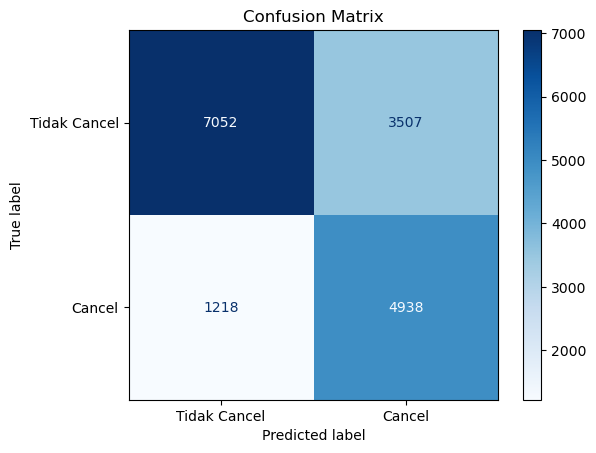

In [84]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Cancel', 'Cancel'])

# Tampilkan
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Berdasarkan hasil diatas:
- True Positives (TP): 4938 — prediksi “Cancel” yang benar
- True Negatives (TN): 7052 — prediksi “Tidak Cancel” yang benar
- False Positives (FP): 3507 — prediksi “Cancel” padahal tidak
- False Negatives (FN): 1218 — prediksi “Tidak Cancel” padahal cancel beneran

Kesimpulan:
- Recall class “Cancel” =
$$
\text{Recall(+)} = \frac{TP}{TP + FN} = \frac{4938}{4938 + 1218} = 0.80
$$

- Artinya: 80% cancelasi berhasil terdeteksi.

## Feature Importances

Mari kita melihat feature importance di model XGBoost kita

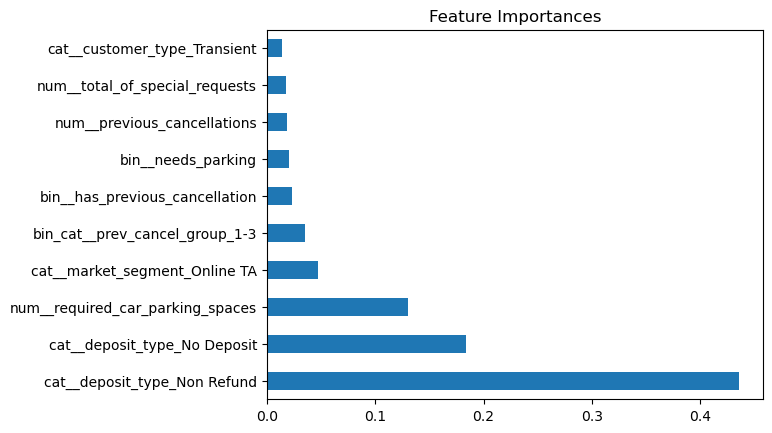

In [85]:
# Dapatkan feature importances + nama fitur final
importances = pd.Series(
    best_model['model'].feature_importances_,
    preprocessor.get_feature_names_out()
).sort_values(ascending=False)

# Ambil top 10
coef1 = importances.head(10)

# Plot
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

### Terlihat bahwa ternyata untuk model XGBoost kita:

Grafik menunjukkan importance relatif dari setiap fitur dalam memprediksi pembatalan reservasi (is_canceled). Berikut adalah urutan fitur berdasarkan pentingnya:

1. cat_deposit_type_Non Refund :
    - Importance : Tertinggi (sekitar 0.45)
    - Artinya: Fitur ini paling berpengaruh dalam memprediksi pembatalan .
    - Interpretasi : Tamu dengan jenis deposit "Non Refund" cenderung memiliki risiko pembatalan yang lebih tinggi dibandingkan jenis deposit lainnya.
2. cat_deposit_type_No Deposit :
    - Importance : Kedua tertinggi (sekitar 0.18)
    - Artinya: Fitur ini juga sangat penting.
    - Interpretasi : Tamu tanpa deposit ("No Deposit") memiliki pola pembatalan yang signifikan dibandingkan tamu dengan deposit lainnya.
3. num_required_car_parking_spaces :
    - Importance : Ketiga tertinggi (sekitar 0.12)
    - Artinya: Penting untuk prediksi pembatalan.
    - Interpretasi : Jumlah tempat parkir yang diminta oleh tamu memiliki korelasi dengan pembatalan. Mungkin tamu yang butuh banyak tempat parkir lebih serius tentang reservasi mereka.
4. cat_market_segment_Online TA :
    - Importance : sedang (sekitar 0.05)
    - Artinya : Penting tetapi tidak sebesar dua fitur deposit.
    - Interpretasi : Kelompok tamu dengan segmen pasar Online TA memiliki dampak signifikan terhadap pembatalan.
5. bin_cat_prev_cancel_group_1-3 :
    - Importance : Sedang (sekitar 0.04)
    - Artinya: Penting tetapi tidak sebesar dua fitur deposit.
    - Interpretasi : Kelompok tamu dengan jumlah pembatalan sebelumnya antara 1–3 kali memiliki dampak signifikan terhadap pembatalan saat ini.
6. Lainnya :
    - bin_has_previous_cancellation: Penting rendah.
    - bin_needs_parking: Penting rendah.
    - num_total_of_special_requests: Penting rendah.
    - num_previous_cancellations: Penting rendah.
    - cat_customer_type_Transient: Penting rendah

Untuk kali ini asumsi yang kita akan gunakan adalah cancelasi berpengaruh pada revenue dan operasional, jadi kita akan menggunakan modelnya untuk memfilter siapa yang kumungkinan akan melakukan cancelasi. Dimana berarti model yang kita buat ini akan membantu mengurangi revenue lost dari segi concelation.


## Conclusion & Recommendation

In [86]:
print('Classification Report XGBoost: \n', report_final)

Classification Report XGBoost: 
               precision    recall  f1-score   support

           0       0.85      0.67      0.75     10559
           1       0.58      0.80      0.68      6156

    accuracy                           0.72     16715
   macro avg       0.72      0.74      0.71     16715
weighted avg       0.75      0.72      0.72     16715



📈 Kesimpulan Bisnis dari Model Prediksi Pembatalan Reservasi (XGBoost)
Berdasarkan hasil classification report dan analisis feature importances dari model XGBoost, kita dapat menyimpulkan bahwa jika model ini digunakan untuk mengidentifikasi tamu yang berisiko tinggi membatalkan reservasi, maka:

- Model mampu mendeteksi 80% dari seluruh tamu yang benar-benar akan membatalkan reservasi (berdasarkan recall class 1).
- Artinya, dari 100 tamu yang benar-benar cancel, sekitar 80 orang berhasil diidentifikasi lebih awal .
- Namun, precision model untuk kelas 1 hanya sebesar 58% , artinya:
    - Dari 100 tamu yang diprediksi akan cancel, hanya 58 orang yang benar-benar jadi cancel .
    - Sisanya (42 tamu) adalah false positive → mereka sebenarnya tidak jadi cancel, tapi model memprediksikan demikian.

🔍 Insight dari Feature Importances
Berdasarkan analisis feature importances:

Fitur Paling Penting:
1. `cat_deposit_type_Non Refund` → Tertinggi
    - Tamu dengan deposit jenis ini cenderung melakukan cancel, kemungkinan karena alasan kuat.
2. `cat_deposit_type_No Deposit` → Kedua tertinggi
    - Risiko pembatalan tinggi karena tidak ada uang yang hilang jika batal.
3. `num_required_car_parking_spaces`
    - Jumlah tempat parkir yang diminta berkorelasi dengan komitmen tamu.
4. `bin_cat_prev_cancel_group_1-3`
    - Riwayat pembatalan 1–3 kali meningkatkan risiko cancel ulang.

💼 Simulasi Bisnis Berdasarkan Hasil Model
1. Asumsi Dasar
    - Total reservasi : 200 tamu
    - Rata-rata revenue per kamar (RevPAR) : €65
      (Sumber : https://www.christie.com/news-resources/press-releases/portugal-hotel-market-snapshot-2024-launch/)
    - Model memiliki recall = 80%, precision = 58%
2. Tanpa Model (Semua Reservasi Diterima)
    - Semua 200 kamar diproses
    - Dari 200 tamu, misalnya:
        - 100 tamu cancel
        - 100 tamu tetap datang
    - Kehilangan pendapatan karena pembatalan:
        - 100 x €65 = €6.500
3. Dengan Model (Prediksi Cancel Digunakan untuk Antisipasi)

✅ Apa yang terjadi?

    - 80 tamu yang akan cancel berhasil dideteksi → bisa dikelola lebih baik atau ditolak (jika strategi antisipatif diterapkan)
    - 20 tamu yang akan cancel tidak terdeteksi (False Negative) → tetap diproses → tetap rugi
    - 42 tamu salah diprediksi sebagai akan cancel (False Positive) → padahal mereka akan datang, tapi hotel tidak menyiapkan kamar → opportunity loss

💰 Hitungan Kerugian & Penghematan

    - Kerugian akibat False Negative (tamu cancel yang tidak terdeteksi):
        - 20 x €65 = €1.300
    - Opportunity Loss akibat False Positive (tamu yang seharusnya datang tapi ditolak):
        - 42 x €65 = €2.730
    - Total potensi kerugian dengan model :
        - €1.300 + €2.730 = €4.030
    - Penghematan dibanding tanpa model :
        - €6.500 – €4.030 = €2.470
    - % Penghematan :
        - (€2.470 / €6.500) * 100 ≈ 38%

4. Perbandingan Akhir
| Skema | Revenue Loss Total | Opportunity Loss | Total Potential Loss | Penghematan |
| --- | --- | --- | --- | --- |
| Tanpa Model | €6.500 | - | €6.500 | - |
| Dengan Model | - | €4.030 |  €4.030 | €2.470 (=38%) |

Ini berarti, model membantu mengurangi potensi kerugian secara signifikan, meskipun masih ada trade-off dalam bentuk false positives.

📊 Solusi yang Ditawarkan & Dampaknya (Measurable)
| Aspek | Deskripsi |
| --- | --- |
| Penghematan Pendapatan | Berdasarkan simulasi pada batch 200 reservasi, model mampu mengurangi kerugian sebesar €2.470 per batch (≈38%) dibandingkan tanpa model. Jika ada 100 batch/hari (20.000 reservasi), potensi penghematan bisa mencapai €247.000/hari. |
| Efisiensi Manajemen Kamar | Dengan antisipasi pembatalan lebih awal, hotel bisa melakukan overbooking secara aman atau menawarkan promo last-minute untuk mengisi kamar kosong. |
| Strategi Retensi Tamu | Dengan informasi tambahan dari feature importances, hotel bisa fokus pada tamu berisiko tinggi cancel dan memberikan penawaran khusus untuk meningkatkan komitmen mereka. |

🤝 Kapan Model Bisa Digunakan? Dan Kapan Harus Waspada?
1. Bisa digunakan :
   - Saat ingin mendeteksi pembatalan dini
   - Saat memiliki data historis lengkap
2. Waspada :
   - Jika tidak punya akses real-time ke data
   - Jika tujuan utama adalah memaksimalkan occupancy rate
3. Jangan digunakan :
   - Saat data sangat sedikit atau tidak relevan
  
⚠️ Batasan-Batasan Proyek
1. Data
    - Dataset bersifat historical dan berasal dari satu sumber (Portugal, hotel tipe tertentu)
        -> Kumpulkan data dari lebih banyak sumber dan variasi hotel untuk generalisasi lebih baik
2. Model
    - XGBoost sensitif terhadap imbalance class dan tidak selalu menjelaskan kenapa tamu cancel
        -> Gunakan model interpretabel (misal: SHAP + Logistic Regression) untuk insight lebih dalam
3. Waktu & Sumber Daya
    - Hyperparameter tuning dan feature engineering dilakukan secara manual dan terbatas
        -> Gunakan AutoML atau pipeline otomatisasi untuk efisiensi

✅ Kesimpulan Utama
Dengan menggunakan model prediksi pembatalan ini, hotel dapat: 

- Mengurangi kerugian finansial dari pembatalan sebesar 38% per batch reservasi.
- Meningkatkan efisiensi alokasi kamar dengan antisipasi risiko pembatalan.
- Memberikan insight bisnis untuk strategi pemasaran dan retensi tamu.

Meskipun model belum sempurna (masih ada false positive), manfaatnya tetap besar, terutama pada volume reservasi yang tinggi dan musim ramai, di mana alokasi kamar sangat kritis.

## Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi:
1. Rekomendasi Strategi Bisnis:
    - Segmentasi pelanggan berdasarkan jenis deposit :
        - Untuk tamu dengan deposit "No Deposit", lakukan follow-up tambahan atau tawarkan insentif untuk mengurangi risiko cancel.
    - Tingkatkan commitment tamu dengan layanan tambahan :
        - Misalnya, promo parkir gratis untuk tamu yang memesan banyak ruang parkir → meningkatkan loyalitas.
    - Strategi personalisasi untuk riwayat pembatalan :
        - Tamu yang sudah pernah cancel sebelumnya → beri penawaran eksklusif agar tidak cancel lagi.
    - Optimalkan penggunaan OTA (Online Travel Agency) :
        - Gunakan data booking dari OTA untuk identifikasi pola pembatalan dan optimalkan pricing strategy.
2. Rekomendasi pengembangan lanjutan :
    - Data tambahan : Tambahkan fitur baru seperti durasi antara booking dan check-in, metode pembayaran, atau review pelanggan.
    - Model Ensemble : Gabungkan beberapa model (XGBoost + LightGBM + Logistic Regression) untuk hasil lebih stabil.
    - Threshold Tuning Otomatis : Buat sistem threshold dinamis berdasarkan musim, harga kamar, atau jenis tamu.
    - Real-Time Inference : Bangun API atau dashboard yang terhubung dengan sistem booking untuk prediksi live.
    - Monitoring Model : Buat sistem monitoring untuk melihat apakah model masih valid saat ada perubahan musiman atau tren pasar baru.
    - A/B Testing : Uji coba model di satu cabang hotel dan bandingkan dengan yang tidak pakai model untuk lihat dampak riil.

In [87]:
## Menyimpan file ke pickle

# import joblib

# # Memasukkan Threshold
# BEST_THRESHOLD = 0.45

# # Simpan model + threshold dalam satu file
# joblib.dump({
#     'model': best_model,
#     'threshold': BEST_THRESHOLD
# }, 'final_model_with_threshold.pkl')

# print("Model + Threshold berhasil disimpan sebagai final_model_with_threshold.pkl")

Model + Threshold berhasil disimpan sebagai final_model_with_threshold.pkl
